# Preconditioner Series: Cholesky Decomposition

In this notebook, we implement our own Cholesky decomposition algorithm and compare its performance to NumPy's implementation. We also explore variants of the Cholesky decomposition such as:
- Cholesky-Banachiewicz factorization
- Cholesky-Crout factorization
- LDL
- Incomplete Cholesky factorization

If you are unfamiliar with preconditioners, I suggest looking through the ['Preconditioner Series: Introduction to Preconditioners']() notebook first.

## Imports

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix
# from sksparse.cholmod import cholesky as sp_cholesky
from scipy.linalg import ldl
from scipy import sparse
from numba import jit

%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

## Helper methods

In [94]:
def make_sparsespd_matrix(n, density=0.05):
    A = sparse.random(n, n, density)
    A = A @ A.T
    
    A = A + n * sparse.eye(n)
        
    return A

## What is it?

The Cholesky decomposition offers an efficient method to calculate numerical solutions to linear equations $Ax=b$ when $A$ is **symmetric (Hermitian if complex)** and **positive definite**. When this is the case, we can decompose $A$ into two matrices:

$$ A=LL^* $$

where $L$ is a lower triangular matrix with real, positive diagonal entries, and $L^*$ is the conjugate transpose of $L$. In the case that $A$ is symmetric and positive definite, $L^*=L^T$.

## Why do it?

When solving linear equations $Ax=b$, the Cholesky decomposition breaks down $Ax=b$ into easier problems. Here are the steps:

1. Cholesky decomposition:  $$ A=LL^* $$
2. Substitute $LL^*$ for $A$:  $$ Ax=LL^*x=b $$
3. Create a new variable $y$:  $$ y=L^*x $$
4. Substitute $y$ into equation from (2) and solve for $y$:  $$ Ly=b $$
5. Solve for $x$:  $$ L^*x=y $$

The efficiency of this method stems from the fact that $L$ and $L^*$ are both triangular matrices, which means that steps 4 and 5 can be performed efficiently.

## How do we do it?

The Cholesky-Banachiewicz and Cholesky-Crout algorithms for the Cholesky decomposition are quite simple and can be derived by writing out the decomposition of A in terms of variables:

<img src="img/cholesky_deriv.png" alt="term-document matrix" style="width: 60%"/>

From the matrix above, we can derive separate formulas for the diagonals and non-diagonal elements of $L$ for $A$ with $i$ rows and $k$ columns:

$$\begin{align}
l_{kk} &= \sqrt{a_{kk}-\sum_{j=1}^{k-1}l_{kj}^2}\\
l_{ik} &= \frac{1}{l_{kk}}\bigg(a_{ik}-\sum_{j=1}^{k-1}l_{ij}l_{kj}\bigg)\ \ \ \text{for}\ i>k
\end{align}$$

The only difference between the two algorithms is the order by which the elements of $L$ are calculated. In Cholesky-Banachiewicz, the elements are calculated row-by-row starting from the top left. Cholesky-Crout starts at the top left as well but proceeds column-by-column.

## Cholesky decomposition from scratch

Here I have a function that performs the Cholesky decomposition using the Cholesky-Banachiewicz algorithm. It is not the most efficient implementation, but, in my opinion, it is easy to read and that is what I prioritized.

In [95]:
def my_cholesky(A):
    rows, _ = A.shape
    L = np.zeros((rows, rows))
    
    L[0, 0] = np.sqrt(A[0, 0])
    
    for i in range(1, rows):
        for k in range(i + 1):
            if (i == k):
                L[i, k] = np.sqrt(A[i, k] - sum([L[k, j] ** 2 for j in range(k)]))
            else:
                L[i, k] = (A[i, k] - sum([L[i, j] * L[k, j] for j in range(k)])) / L[k, k]
    return L

### Comparison to NumPy's *cholesky*

Let's first create a symmetric, positive definite matrix.

In [96]:
A = make_spd_matrix(5)
A.shape

(5, 5)

In [97]:
%time L_np = np.linalg.cholesky(A)
L_np

CPU times: user 84 µs, sys: 5 µs, total: 89 µs
Wall time: 94.2 µs


array([[ 1.37932,  0.     ,  0.     ,  0.     ,  0.     ],
       [-1.17999,  0.61691,  0.     ,  0.     ,  0.     ],
       [-0.60063,  0.50047,  0.53719,  0.     ,  0.     ],
       [-1.05437, -0.14315,  0.30996,  0.71592,  0.     ],
       [-0.47166, -0.06155, -0.09125,  0.09037,  0.4519 ]])

In [98]:
%time L = my_cholesky(A)
L, np.allclose(L, L_np)

CPU times: user 98 µs, sys: 5 µs, total: 103 µs
Wall time: 107 µs


(array([[ 1.37932,  0.     ,  0.     ,  0.     ,  0.     ],
        [-1.17999,  0.61691,  0.     ,  0.     ,  0.     ],
        [-0.60063,  0.50047,  0.53719,  0.     ,  0.     ],
        [-1.05437, -0.14315,  0.30996,  0.71592,  0.     ],
        [-0.47166, -0.06155, -0.09125,  0.09037,  0.4519 ]]), True)

Although my implementation of the Cholesky decomposition takes roughly 1.5 to 2 times to that of NumPy, we got the same answer. For larger matrices, my implementation still computes the answer correctly albeit orders of magnitude slower.

In [99]:
A = make_spd_matrix(100)
%time L_np = np.linalg.cholesky(A)
%time L = my_cholesky(A)
np.allclose(L_np, L)

CPU times: user 191 µs, sys: 3 µs, total: 194 µs
Wall time: 201 µs
CPU times: user 263 ms, sys: 2.82 ms, total: 265 ms
Wall time: 201 ms


True

Let's try speeeding things up with Numba's @jit decorator.

In [100]:
@jit
def my_cholesky_jit(A):
    rows, cols = A.shape
    L = np.zeros((rows, cols))
    
    L[0, 0] = np.sqrt(A[0, 0])
    
    for i in range(1, rows):
        for k in range(i + 1):
            if (i == k):
                L[i, k] = np.sqrt(A[i, k] - sum([L[k, j] ** 2 for j in range(k)]))
            else:
                L[i, k] = (A[i, k] - sum([L[i, j] * L[k, j] for j in range(k)])) / L[k, k]
    return L

In [101]:
%time L_jit = my_cholesky_jit(A)

AssertionError: Failed at object (object mode frontend)


## Variants to the Cholesky decomposition

Several variants to the original Cholesky decomposition exist. Here, I describe and implement several of them.

### LDL

An alternative to the Cholesky decomposition is the LDL decomposition, also known as the symmetric indefinite factorization. 

<img src="img/ldl_3by3.png" alt="term-document matrix" style="width: 70%"/>

$$\begin{align}D_j &= A_{jj}-\sum_{k=1}^{j-1}L_{jk}^2D_k \\
L_{ij} &= \frac{1}{D_j}\bigg(A_{ij}-\sum_{k=1}^{j-1}L_{ik}L_{jk}D_k \bigg)\ \text{for}\ i>j\end{align}$$

In [102]:
def my_ldl(A):
    rows, _ = A.shape
    L = np.eye(rows)
    D = np.zeros((rows,))
    
    for i in range(1, rows):
        for j in range(i + 1):
            D[j] = A[j,j] - sum([D[k] * L[j, k] ** 2 for k in range(j)])
            L[i, j] = (A[i, j] - sum([L[i, k] * L[j, k] * D[k] for k in range(j)])) / D[j]
    return L, D

In [103]:
A = make_spd_matrix(5)

In [104]:
%time L, D = my_ldl(A)
L, np.diag(D), np.allclose(A, L @ np.diag(D) @ L.T)

CPU times: user 259 µs, sys: 6 µs, total: 265 µs
Wall time: 271 µs


(array([[ 1.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [-0.43633,  1.     ,  0.     ,  0.     ,  0.     ],
        [ 0.2782 , -0.48509,  1.     ,  0.     ,  0.     ],
        [-1.28597,  0.20192,  0.72768,  1.     ,  0.     ],
        [-0.24145, -0.22716, -0.39988,  0.15588,  1.     ]]),
 array([[1.58466, 0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.6108 , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.19978, 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.85413, 0.     ],
        [0.     , 0.     , 0.     , 0.     , 0.24568]]),
 True)

In [105]:
%time lu, d, perm = ldl(A)
lu, d, perm

CPU times: user 637 µs, sys: 165 µs, total: 802 µs
Wall time: 989 µs


(array([[ 1.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [-0.43633,  1.     ,  0.     ,  0.     ,  0.     ],
        [ 0.2782 , -0.48509,  1.     ,  0.     ,  0.     ],
        [-1.28597,  0.20192,  0.72768,  1.     ,  0.     ],
        [-0.24145, -0.22716, -0.39988,  0.15588,  1.     ]]),
 array([[1.58466, 0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.6108 , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.19978, 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.85413, 0.     ],
        [0.     , 0.     , 0.     , 0.     , 0.24568]]),
 array([0, 1, 2, 3, 4]))

### Incomplete Cholesky with zero-fill

Of course, like any decomposition algorithm in numerical linear algebra, the Cholesky decomposition has a variation that calculates a sparse approximation of it.

$$ A\approx LL^T $$

The first of these is incomplete Cholesky with zero-fill, also known as IC(0), where the Cholesky factor $L$ has the same sparsity as $A$. This is calculated by only retaining nonzeros in $L$ where $A$ contained nonzeros.

In [106]:
def ichol_zero(A):
    rows, _ = A.shape
    L = np.zeros((rows, rows))
    
    L[0, 0] = np.sqrt(A[0, 0])
    
    for i in range(1, rows):
        for k in range(i + 1):
            if A[i, k] != 0:
                if i == k:
                    L[i, k] = np.sqrt(A[i, k] - sum([L[k, j] ** 2 for j in range(k)]))
                else:
                    L[i, k] = (A[i, k] - sum([L[i, j] * L[k, j] for j in range(k)])) / L[k, k]
    return L

We can see that $L$ computed using IC(0) does in fact have zero entries where $A$ had zeros.

In [107]:
A = np.array([[25, 15, -5], [15, 18, 0], [-5, 0, 11]])

L = my_cholesky(A)
L_zero = ichol_zero(A)

A, L, L_zero

(array([[25, 15, -5],
        [15, 18,  0],
        [-5,  0, 11]]), array([[ 5.,  0.,  0.],
        [ 3.,  3.,  0.],
        [-1.,  1.,  3.]]), array([[ 5.     ,  0.     ,  0.     ],
        [ 3.     ,  3.     ,  0.     ],
        [-1.     ,  0.     ,  3.16228]]))

Whereas the $L$ from standard Cholesky factorization allows the reconstruction of $A$ completely, the Cholesky factor from IC(0) can only reconstruct $A$ partially.

In [108]:
print(L @ L.T)

[[25. 15. -5.]
 [15. 18.  0.]
 [-5.  0. 11.]]


In [109]:
print(L_zero @ L_zero.T)

[[25. 15. -5.]
 [15. 18. -3.]
 [-5. -3. 11.]]


### Incomplete Cholesky with threshold dropping

A similar IC method to IC(0) is incomplete Cholesky with threshold dropping (ICT). The idea is to drop non-diagonal entries that are less than or equal to the drop tolerance in magnitude.

Instead of merely testing if an entry $|a_{i,j}|>tol$, which will introduce different amounts of fill for matrices of similar sparsity, the test can be modified to compare $a_{i,j}$ to the its corresponding diagonal entries $a_{i,i}$ and $a_{j,j}$:

$$ \text{retain}\ a_{i,j}\ \text{if}\ (a_{i,j})^2>(tol)^2\times a_{i,i}a_{j,j} $$

In [114]:
def ichol_drop(A, tol=1e-3):
    rows, _ = A.shape
    L = np.zeros((rows, rows))
    
    L[0, 0] = np.sqrt(A[0, 0])
    
    for i in range(1, rows):
        for k in range(i + 1):
            if i == k:
                L[i, k] = np.sqrt(A[i, k] - sum([L[k, j] ** 2 for j in range(k)]))
            else:
                l = (A[i, k] - sum([L[i, j] * L[k, j] for j in range(k)])) / L[k, k]
                if l ** 2 > tol ** 2 * L[i, i] * L[k, k]:
                    L[i, k] = l
    return L

To test this algorithm, we need to create a sparse symmetric positive definite matrix.

In [119]:
A = make_sparsespd_matrix(100)

L = my_cholesky(A)
L_drop = ichol_drop(A, tol=1)

Comparing the Frobenius norm of the matrix reconstructed from the Cholesky factors, it is obvious that the standard Cholesky factorization performs much better.

In [120]:
np.linalg.norm(A - L @ L.T), np.linalg.norm(A - L_drop @ L_drop.T)

(1.1008493973200436e-13, 1.1008493973200436e-13)

Of course, as the drop tolerance is decreased, the error between the original matrix $A$ and the reconstructed matrix $LL^T$ decreases. 

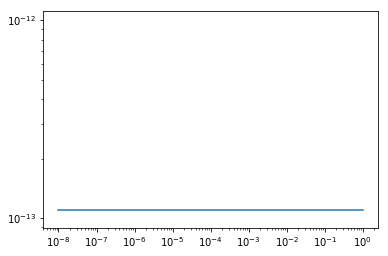

In [126]:
tol_range = np.logspace(-8, 0, num=9, base=10.0)
nrm = []

for tol in tol_range:
    L_drop = ichol_drop(A, tol)
    nrm = np.append(nrm, np.linalg.norm(A - L_drop @ L_drop.T))
    
plt.plot(tol_range, nrm);
plt.xscale('log')
plt.yscale('log')

Here we can see that sparsity pattern of the matrix $A$ created.

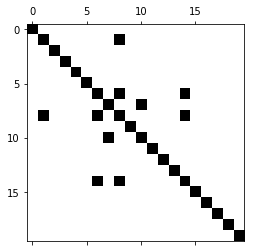

In [13]:
A = make_sparsespd(20).todense()
plt.spy(A);

Now, we can test our incomplete Cholesky factorization algorithm.

CPU times: user 697 µs, sys: 11 µs, total: 708 µs
Wall time: 704 µs


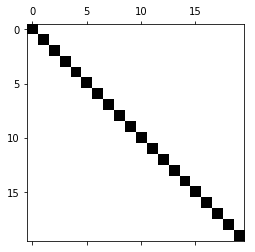

In [14]:
%time K = my_ichol(A)

plt.spy(K);

Of course, as the drop tolerance is decreased, the error between the original matrix $A$ and the reconstructed matrix $LL^T$ decreases. 

#### Comparison with *scikit.sparse* implementation

As I did before, I compare the results of my function with that of a function written using the *scipy.sparse* library.

#### Comparison with (complete) Cholesky factorization

By comparing the sparsity patterns of the two methods, we can see how much 
memory can be saved at the expense of some accuracy.

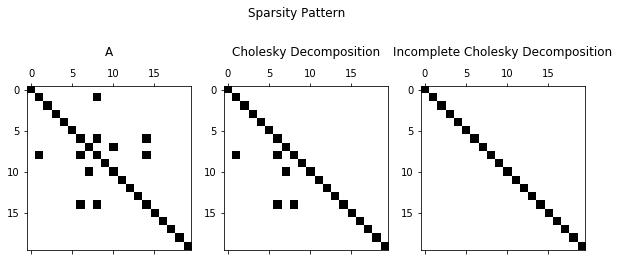

In [15]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
plt.spy(A);
ax1.set_title('A', y=1.15);

ax2 = fig.add_subplot(1, 3, 2)
plt.spy(np.linalg.cholesky(A));
ax2.set_title('Cholesky Decomposition', y=1.15);

ax3 = fig.add_subplot(1, 3, 3)
plt.spy(K);
ax3.set_title('Incomplete Cholesky Decomposition', y=1.15);

plt.suptitle('Sparsity Pattern', y=0.95);

## Resources

[Cholesky decomposition algorithm derivation](https://rosettacode.org/wiki/Cholesky_decomposition)

[MATLAB: Cholesky factorization](https://www.mathworks.com/help/matlab/ref/chol.html)

[MATLAB: Incomplete Cholesky factorization](https://www.mathworks.com/help/matlab/ref/ichol.html)